In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm as tqdm

REBUILD_DATA = True

In [4]:
class DogsVsCats():
    def __init__(self):
        self.IMG_SIZE = 50
        self.CATS = "drive/MyDrive/PetImages/Cat"
        self.DOGS = "drive/MyDrive/PetImages/Dog"
        self.LABELS = {self.CATS: 0, self.DOGS: 1}
        self.training_data = []
        self.catcount = 0
        self.dogcount = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            count = 0
            for f in tqdm(os.listdir(label)):
                if "jpg" in f and count < 1000:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])
                        if label == self.CATS:
                            self.catcount += 1
                        elif label == self.DOGS:
                            self.dogcount += 1

                    except Exception as e:
                        print(label, f, str(e))
                    count += 1

        np.random.shuffle(self.training_data)
        # np.save("training_data.npy", np.array(self.training_data, dtype=object))
        print('Cats:',self.catcount)
        print('Dogs:',self.dogcount)

if REBUILD_DATA:
    dogsvscats = DogsVsCats()
    dogsvscats.make_training_data()

drive/MyDrive/PetImages/Cat


 28%|██▊       | 956/3456 [00:43<00:14, 176.37it/s]

drive/MyDrive/PetImages/Cat 9778.jpg OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



100%|██████████| 3456/3456 [00:43<00:00, 79.64it/s]


drive/MyDrive/PetImages/Dog


  7%|▋         | 74/1079 [00:08<01:05, 15.33it/s]

drive/MyDrive/PetImages/Dog 11410.jpg OpenCV(4.8.0) /io/opencv/modules/imgproc/src/resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'resize'



100%|██████████| 1079/1079 [00:13<00:00, 78.84it/s]

Cats: 999
Dogs: 999


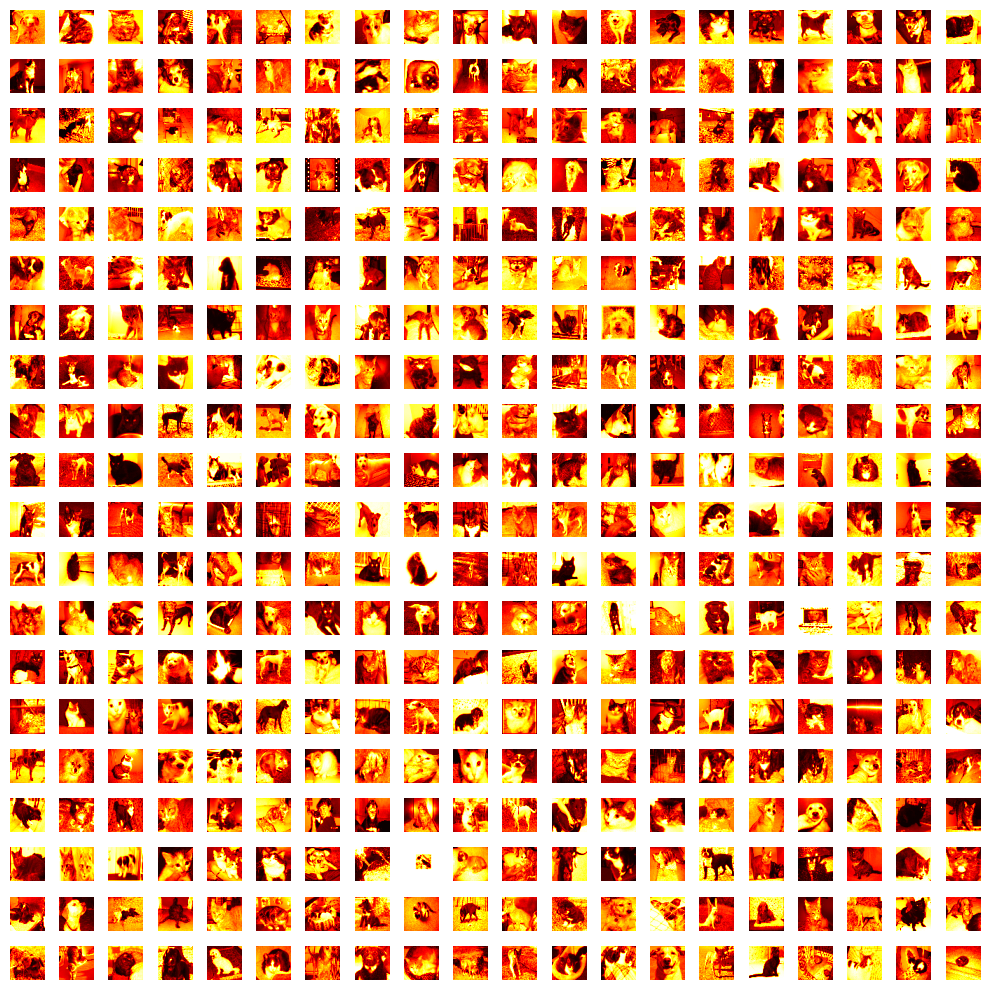

In [ ]:
import matplotlib.pyplot as plt

# Define the number of rows and columns for the subplot grid
num_rows = 20
num_cols = 20

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

for d, ax in zip(dogsvscats.training_data, axes):
      # Plot the image on the current subplot
      ax.imshow(d[0], cmap='hot')
      ax.axis('off')  # Turn off axis labels

# Adjust layout to prevent overlap of subplots
plt.tight_layout()

plt.show()



In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, 5)
    self.conv2 = nn.Conv2d(32, 64, 5)
    self.conv3 = nn.Conv2d(64, 128, 5)

    x = torch.randn(50,50).view(-1,1,50,50)
    self._to_linear = None
    self.convs(x)

    self.fc1 = nn.Linear(self._to_linear, 512)
    self.fc2 = nn.Linear(512, 2)

  def convs(self, x):
    x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = x.view(-1, self._to_linear)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return F.softmax(x, dim=1)

device = torch.device("cuda:0")
net = Net().to(device)

In [5]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in dogsvscats.training_data]).view(-1,50,50)
X = X/255.0
y = torch.Tensor([i[1] for i in dogsvscats.training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

199


<ipython-input-5-702a4e5a5c03>:4: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X = torch.Tensor([i[0] for i in dogsvscats.training_data]).view(-1,50,50)


In [6]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

1799
199


In [33]:
def test(net):
  correct = 0
  total = 0
  with torch.no_grad():
    for i in tqdm(range(len(test_X)), position=0, leave=True):
      real_class = torch.argmax(test_y[i]).to(device)
      net_out = net(test_X[i].view(-1,1,50,50).to(device))[0]
      predicted_class = torch.argmax(net_out)
      if predicted_class == real_class:
        correct += 1
      total += 1

  print("Accuracy: ", round(correct/total, 3))

In [10]:
print(torch.cuda.is_available())
device = torch.device("cuda:0")
device

True


Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [34]:
BATCH_SIZE = 50
EPOCHS = 10

def train(net):
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
  loss_function = nn.MSELoss()
  for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE), position=0):
      batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
      batch_y = train_y[i:i+BATCH_SIZE]

      batch_X, batch_y = batch_X.to(device), batch_y.to(device)

      net.zero_grad()

      outputs = net(batch_X)
      loss = loss_function(outputs, batch_y)
      loss.backward()
      optimizer.step()

    print(f"Epoch: {epoch}, loss: {loss}")
    test(net)

train(net)

100%|██████████| 36/36 [00:00<00:00, 147.29it/s]


Epoch: 0, loss: 0.026224518194794655


100%|██████████| 1799/1799 [00:01<00:00, 1437.41it/s]


Accuracy:  0.986


100%|██████████| 36/36 [00:00<00:00, 215.96it/s]


Epoch: 1, loss: 0.002880553714931011


100%|██████████| 1799/1799 [00:01<00:00, 1387.41it/s]


Accuracy:  0.997


100%|██████████| 36/36 [00:00<00:00, 214.54it/s]


Epoch: 2, loss: 0.01985694095492363


100%|██████████| 1799/1799 [00:01<00:00, 1471.67it/s]


Accuracy:  0.998


100%|██████████| 36/36 [00:00<00:00, 212.96it/s]


Epoch: 3, loss: 2.0829721281145908e-10


100%|██████████| 1799/1799 [00:01<00:00, 1474.76it/s]


Accuracy:  0.999


100%|██████████| 36/36 [00:00<00:00, 213.62it/s]


Epoch: 4, loss: 2.608750904187218e-08


100%|██████████| 1799/1799 [00:01<00:00, 1442.51it/s]


Accuracy:  0.999


100%|██████████| 36/36 [00:00<00:00, 213.55it/s]


Epoch: 5, loss: 1.1297827562373186e-08


100%|██████████| 1799/1799 [00:01<00:00, 1485.79it/s]


Accuracy:  0.999


100%|██████████| 36/36 [00:00<00:00, 215.37it/s]


Epoch: 6, loss: 2.248480290845123e-09


100%|██████████| 1799/1799 [00:01<00:00, 1302.46it/s]


Accuracy:  0.999


100%|██████████| 36/36 [00:00<00:00, 202.45it/s]


Epoch: 7, loss: 1.730316778747465e-09


100%|██████████| 1799/1799 [00:02<00:00, 886.67it/s]


Accuracy:  0.999


100%|██████████| 36/36 [00:00<00:00, 121.02it/s]


Epoch: 8, loss: 1.6776162681253481e-09


100%|██████████| 1799/1799 [00:03<00:00, 583.72it/s]


Accuracy:  0.999


100%|██████████| 36/36 [00:00<00:00, 145.34it/s]


Epoch: 9, loss: 1.630332424618075e-09


100%|██████████| 1799/1799 [00:01<00:00, 1010.80it/s]

Accuracy:  0.999


In [37]:
def fwd_pass(X, y, train=False):
  if train:
    net.zero_grad()
  outputs = net(X)
  matches = [torch.argmax(i) == torch.argmax(j) for i, j in zip(outputs, y)]
  acc = matches.count(True)/len(matches)
  loss = loss_function(outputs, y)

  if train:
    loss.backward()
    optimizer.step()
  return acc, loss


In [43]:
def test(size=32):
  random_start = np.random.randint(len(test_X)-size)
  X, y = test_X[random_start:random_start+size], test_y[random_start:random_start+size]
  with torch.no_grad():
    val_acc, val_loss = fwd_pass(X.view(-1,1,50,50).to(device), y.to(device))
  return val_acc, val_loss

val_acc, val_loss = test(size=100)
print(val_acc, val_loss)

0.53 tensor(0.4440, device='cuda:0')
